In [1]:
#импортируем необходимые библиотеки
import os
import torch
import timm
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms


/Users/nikolajnecaev/anaconda3/envs/image/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#определим устройство, где проводить вычисления (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Функция для вывода изображений
def image_shower(images, labels, classes, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image / 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))


In [18]:
# Имена классов
classes_noise = ("broken", "clear")
classes_animal = ("no_animal", "animal")

# Путь до датасета
PATH = "./dataset"

# Зададим какие преобразования необходимо сделать с каждым изображением
transform = transforms.Compose(
    [transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# noise data
trainset_noise = torchvision.datasets.ImageFolder(
    os.path.join(PATH, "train_noise"), 
    transform=transform)

trainloader_noise = torch.utils.data.DataLoader(
    trainset_noise, batch_size=32, shuffle=True
    )

testset_noise = torchvision.datasets.ImageFolder(
    os.path.join(PATH, "test_noise"), transform=transform
    )
testloader_noise = torch.utils.data.DataLoader(
    testset_noise, batch_size=32, shuffle=True
    )

# animal data
trainset_animal = torchvision.datasets.ImageFolder(
    os.path.join(PATH, "train_ani"), transform=transform
    )
trainloader_animal = torch.utils.data.DataLoader(
    trainset_animal, batch_size=32, shuffle=True
    )




In [19]:
testset_animal = torchvision.datasets.ImageFolder(
    os.path.join(PATH, "test_ani"), transform=transform
    )
testloader_animal = torch.utils.data.DataLoader(
    testset_animal, batch_size=32, shuffle=True
    )

Real Labels:  clear clear clear broken


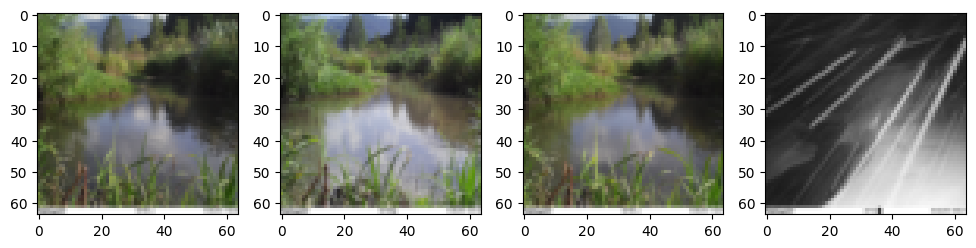

In [20]:
# look at image
images, labels = next(iter(trainloader_noise))
image_shower(images, labels, classes_noise)

In [6]:
# dowanload EfficientNet
model = timm.create_model('efficientnet_b5', pretrained=True)

# classifier
model.classifier = nn.Linear(model.num_features, 1)

# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# study the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader_noise):
        inputs, labels = data
        labels = labels.unsqueeze(1).float()  # Преобразование меток в float для совместимости с BCEWithLogitsLoss
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader_noise)}")


KeyboardInterrupt: 

In [13]:
# Посчитаем точность работы нашего классификатора
correct = 0
total = 0
with torch.no_grad():
    # Переводим модель в режим инференса
    model.eval()
    for data in testloader_noise:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Применяем сигмоиду и задаем порог
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).long().squeeze()
        # Посчитаем общее количество картинок
        total += labels.size(0)
        # Посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" % (100 * correct / total))

Accuracy: 70


Real Labels:  clear broken broken clear
Predicted:  clear broken broken broken


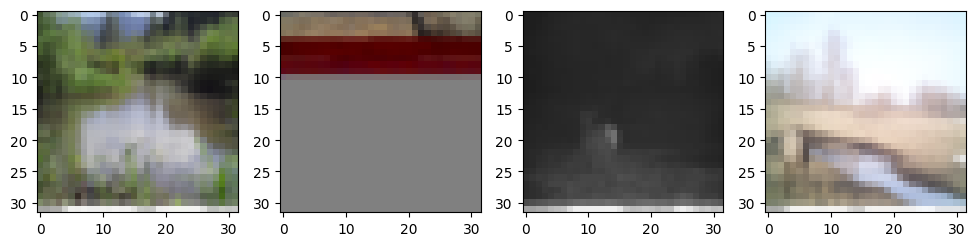

In [15]:
images, labels = next(iter(testloader_noise))
image_shower(images, labels, classes_noise)

outputs = model(images.to(device))
# Применяем сигмоиду и задаем порог
probabilities = torch.sigmoid(outputs)
predicted = (probabilities > 0.5).long().squeeze()

print("Predicted: ", " ".join(
    "%5s" % classes_noise[predict] for predict in predicted[:4]
    )
)

In [21]:
# Загрузка модели для второй итерации классификации
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)

# Заморозка всех слоев кроме классификатора для второй итерации классификации
for name, param in model2.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

# Замена классификатора для второй итерации классификации
model2.classifier = nn.Linear(model2.classifier.in_features, 1)

# Функция потерь и оптимизатор для второй итерации классификации
criterion2 = nn.BCEWithLogitsLoss()
optimizer2 = optim.RMSprop(model2.parameters(), lr=0.001)

# Цикл обучения для второй итерации классификации
num_epochs2 = 10
for epoch in range(num_epochs2):
    running_loss2 = 0.0
    for i, data in enumerate(trainloader_animal):
        inputs2, labels2 = data
        labels2 = labels2.unsqueeze(1).float()
        optimizer2.zero_grad()
        outputs2 = model2(inputs2)
        loss2 = criterion2(outputs2, labels2)
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss2/len(trainloader_animal)}")


Using cache found in /Users/nikolajnecaev/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1, Loss: 0.326073309508237
Epoch 2, Loss: 0.1964364882897247
Epoch 3, Loss: 0.17410183203491297
Epoch 4, Loss: 0.16756449165669354
Epoch 5, Loss: 0.14807219952344894
Epoch 6, Loss: 0.13730885989286684
Epoch 7, Loss: 0.13250098953192885
Epoch 8, Loss: 0.12380664409561591
Epoch 9, Loss: 0.1251468522982164
Epoch 10, Loss: 0.12444446550851518


In [22]:
torch.jit.script(model).save('animals2.pt')

In [23]:
# Посчитаем точность работы нашего классификатора
correct = 0
total = 0
threshold = 0.5  # порог для классификации

with torch.no_grad():
    model2.eval()  # переводим модель в режим оценки
    for data in testloader_animal:
        inputs2, labels2 = data
        inputs2, labels2 = inputs2.to(device), labels2.unsqueeze(1).float().to(device)
        outputs2 = model2(inputs2)
        predicted = torch.sigmoid(outputs2)  # применяем сигмоидную функцию
        predicted = (predicted > threshold).float()  # применяем порог
        total += labels2.size(0)
        correct += (predicted == labels2).sum().item()

print("Accuracy: {:.2f}%".format(100 * correct / total))


Accuracy: 82.00%


Real Labels:  animal no_animal no_animal no_animal
Real Labels:  animal no_animal no_animal no_animal
Predicted:  no_animal no_animal no_animal no_animal


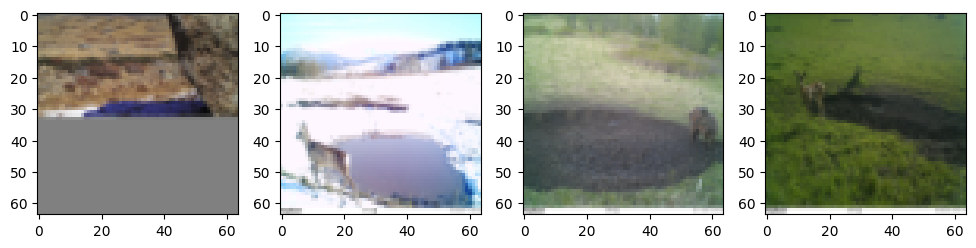

In [26]:
images, labels = next(iter(testloader_animal))
image_shower(images, labels, classes_animal)
outputs = model2(images.to(device))

# Применение сигмоидной функции для конвертации logits в вероятности
probabilities = torch.sigmoid(outputs)

# Классификация изображений
predicted = (probabilities > threshold).float().cpu()

# Вывод реальных и предсказанных меток
print("Real Labels: ", ' '.join('%5s' % classes_animal[label] for label in labels[:4]))
print("Predicted: ", " ".join("%5s" % classes_animal[int(predict)] for predict in predicted.squeeze()[:4]))
